# Lab 3

## Conrad Appel & Eric Hawkins

For this project, we used a collection of images called the ["CIFAR-10 dataset"](http://www.cs.toronto.edu/~kriz/cifar.html), assembled by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The dataset consists of 60,000 32x32 color images, with 10 classes, and 6000 images per class.

This data can be used to train a machine to recognize different things from pictures, such as automobiles, cats, horses, and trucks. The ability of a system to automatically classify images could be used to tag pictures to refine image searches.

In [2]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import os 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import pandas as p
from skimage.feature import match_template
import _pickle as cPickle
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
from random import randint
import copy
import seaborn as sns

numlabels = 10



###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./lab3/imgs/
###

In [3]:
dics = []
for root, directory, files in os.walk('imgs'):
    for f in files:
        if 'data_batch' in f:
            with open(root+'/'+f, 'rb') as fo:
                dics.append(cPickle.load(fo, encoding='latin1'))
                break
total_imgs = []
for dic in dics:
    for i in range(len(dic['data'])):
        curpic = []
        curpic.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
        curpic.append(dic['labels'][i]) # int representing the label
        total_imgs.append(curpic)
        
total_imgs = np.array(total_imgs)
imgs_df = p.DataFrame(total_imgs)
imgs_df.columns = ['oneDColor', 'label']

In [4]:
labels = {}
with open('./imgs/batches.meta', 'rb') as fo:
    labels_tmp = cPickle.load(fo, encoding='latin1')
    for i in range(len(labels_tmp['label_names'])):
        labels[i] = labels_tmp['label_names'][i]

In [5]:
# Function to convert images to grayscale. This makes them significantly
# easier to process.
def toGrayscale(img):
    r, g, b = img[:1024], img[1024:2048], img[2048:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

imgs_df['oneDGray'] = imgs_df['oneDColor'].apply(toGrayscale)

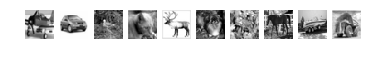

In [6]:
f, axes = plt.subplots(1,10)
for label in range(10):
    axes[label].axis('off')
    axes[label].imshow(imgs_df.loc[lambda df: df.label == label]['oneDGray'].sample(n=1).values[0].reshape((32,32)), cmap=plt.cm.gray)

## Linear Dimensionality Reduction via PCA

In [7]:
# Principal Components Analysis
pcas = []
for label in range(numlabels):
    x = imgs_df.loc[lambda df: df.label == label]
    
    pixels_are_cols = np.zeros(shape=(len(x), 1024))
    for i in range(len(x)):
        cur_pic = x['oneDGray'].values[i]
        for j in range(1024):
            pixels_are_cols[i][j] = cur_pic[j]
    
    x = pixels_are_cols
    y = [True]*len(x)
    n_comps = 50

    pca = PCA(n_components=n_comps)
    X_pca = pca.fit(x)
    pcas.append((x, pca, X_pca))

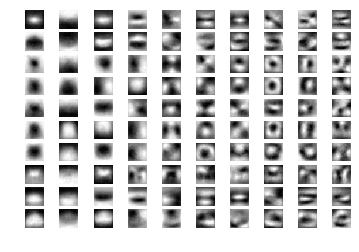

In [8]:
f, axes = plt.subplots(10, numlabels)
for label in range(numlabels):
    axis = axes[label] if numlabels > 1 else axes
    eigenpics = pcas[label][1].components_.reshape((n_comps, 32, 32))
    for i in range(10):
        axis[i].axis('off')
        axis[i].imshow(eigenpics[i].reshape((32,32)), cmap=plt.cm.gray)

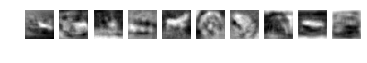

In [9]:
f, axes = plt.subplots(1, numlabels)
for label in range(numlabels):
    axis = axes[label] if numlabels > 1 else axes
    np.random.shuffle(pcas[label][0])
    recd = pcas[label][1].inverse_transform(pcas[label][1].transform(pcas[label][0][0].reshape(1, -1)))
    axis.axis('off')
    axis.imshow(recd.reshape((32,32)), cmap=plt.cm.gray)

## Non-Linear Dimensionality Reduction via Kernel PCA

In [10]:
# Kernel Principal Component Analysis
kpcas = []
for label in range(numlabels):
    x = imgs_df.loc[lambda df: df.label == label]
    
    pixels_are_cols = np.zeros(shape=(len(x), 1024))
    for i in range(len(x)):
        cur_pic = x['oneDGray'].values[i]
        for j in range(1024):
            pixels_are_cols[i][j] = cur_pic[j]
    
    x = pixels_are_cols
    y = [True]*len(x)
    n_comps = 50

    kpca = KernelPCA(n_components=n_comps, kernel='rbf', fit_inverse_transform=True, gamma=15)
    X_kpca = kpca.fit(x)
    kpcas.append((x, kpca, X_kpca))

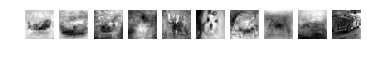

In [22]:
f, axes = plt.subplots(1, numlabels)
for label in range(numlabels):
    axis = axes[label] if numlabels > 1 else axes
    np.random.shuffle(kpcas[label][0])
    recd = kpcas[label][1].inverse_transform(kpcas[label][1].transform(kpcas[label][0][0].reshape(1, -1)))
    axis.axis('off')
    axis.imshow(recd.reshape((32,32)), cmap=plt.cm.gray)

We found 50 components to be a reasonable amount for dimensionality reduction, as this produces recognizable images for both types of PCA used in this report.

After trying both a linear dimensionality reduction (PCA) and a non-linear dimensionality reduction (kernel PCA), we preferred the results of the kernel PCA, as it produced images far closer to the originals than the linear PCA when using 50 components.

## DAISY Feature Extraction

In [13]:
def apply_daisy(row):
    row = row[2]
    feat = daisy(row.reshape((32,32)),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

In [14]:
# calculate bag of features for each image
daisies = np.apply_along_axis(apply_daisy, 1, imgs_df)

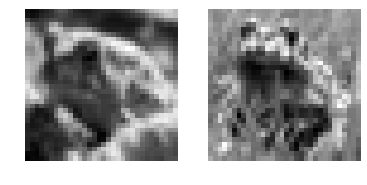

In [15]:
# pick a random image and calculate its distance from the other images according to the DAISY features
index1 = randint(0, len(daisies))

# can only calculate one image's distances at a time because memory things
dist_matrix = pairwise_distances(daisies, daisies[index1].reshape((1, -1))) 
dist_matrix[index1] = np.infty
index2 = np.argmin(dist_matrix)

# display random image and its closest match using the DAISY features
f, axes = plt.subplots(1,2)
axes[0].axis('off')
axes[1].axis('off')
tmp = axes[0].imshow(imgs_df['oneDGray'][index1].reshape((32,32)), cmap=plt.cm.gray)
tmp = axes[1].imshow(imgs_df['oneDGray'][index2].reshape((32,32)), cmap=plt.cm.gray)

Here we used the DAISY Bag of Features Model for feature extraction. This finds the closest match for a random image in our dataset based on DAISY features.

## Differences between instances within classes

In [16]:
mean_distances = []
for i in range(numlabels):
    cur_imgs = imgs_df.loc[lambda df: df.label == i]
    cur_daisies = np.apply_along_axis(apply_daisy, 1, cur_imgs) # TODO: don't need to recalculate these DAISYs
    dist_matrix = pairwise_distances(cur_daisies)
    mean_distances.append(p.DataFrame(dist_matrix).mean().values)

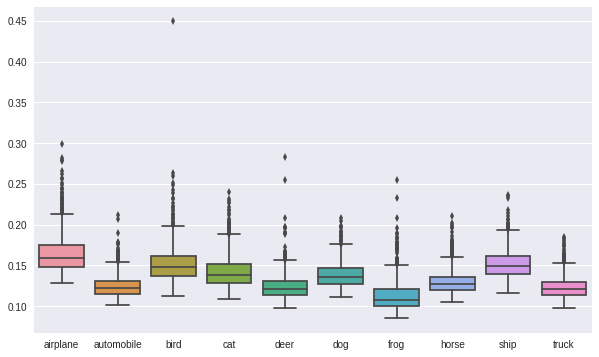

In [17]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=mean_distances)
tmp = ax.figure.get_axes()[0].set_xticklabels(labels.values())

The boxplots above show the distributions of DAISY features for a class of images. The plots show that there is a great deal of variance between images in the same class. This is understandable, since many of the images in each class are from different angles, of different types of the thing in the class (e.g. different breeds of dog, different makes/models of truck).

What is interesting is how concentrated each class is near its median. Airplanes being the most median-concentrated class makes sense, as most airplanes have the same basic shape, regardless of their make.